<table style="border: none" align="center">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="4" color="black"><b>  EXP:1 LinearSVC  </b></font></font></th>
   </tr> 
</table>

In this notebook we demonstrate Model training and adversarial training using ART on the IRIS dataset.

Sensitivity to training set details:
https://nbviewer.jupyter.org/github/Azure/azureml-examples/blob/main/notebooks/train-lightgbm-local.ipynb


## Contents

1.	[Load prereqs and data](#prereqs)
2.  [Exploratory Data Analysis](#eda)
2.  [Data scale, Train and evaluate a baseline classifier](#classifier)
3.  [Adversarially train a robust classifier](#adv_training)
4.	[Evaluate the robust classifier](#evaluation)

<a id="prereqs"></a>
## 1. Load prereqs and data

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
%reload_ext watermark
%watermark

2020-11-25T16:08:03+01:00

CPython 3.8.3
IPython 7.19.0

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 37 Stepping 5, GenuineIntel
CPU cores  : 4
interpreter: 64bit


In [70]:
# Initialization:
%reload_ext autoreload
%autoreload 2

# import warnings filter
import warnings
warnings.filterwarnings('ignore')
# ignore all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [71]:
%reload_ext watermark
%watermark  -d -u -a "Habtamu desalegn" -v -p numpy,pandas,scipy,matplotlib,sklearn,mlxtend

Habtamu desalegn 
last updated: 2020-11-25 

CPython 3.8.3
IPython 7.19.0

numpy 1.19.4
pandas 1.1.3
scipy 1.5.3
matplotlib 3.3.3
sklearn 0.23.2
mlxtend 0.17.3


In [72]:
# Downloading the Libraries and Dependencies:
import os
import numpy as np
import pandas as pd
from IPython.display import Image
from typing import Tuple

%matplotlib inline
import matplotlib.pyplot as plt

#### Loading the IRIS dataset

In [73]:
COLUMNS = ["sepal_length","sepal_width","petal_length","petal_width","species"]
PATH = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
df = pd.read_csv(PATH, header=None, names=COLUMNS)
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [74]:
from sklearn.preprocessing import LabelEncoder

X = df.drop('species', axis=1).values
y = df['species']

enc = LabelEncoder()
y = enc.fit_transform(y)

In [87]:
# Transformed dataframe
df_transformed = pd.DataFrame(
    data=X,
    columns=["sepal_length","sepal_width","petal_length","petal_width"])
df_transformed["species"] = y

# save csv file
df_transformed.to_csv("./data/iris_transformed.csv", index=False)

<a id="eda"></a>
## Exploratory Data Analysis

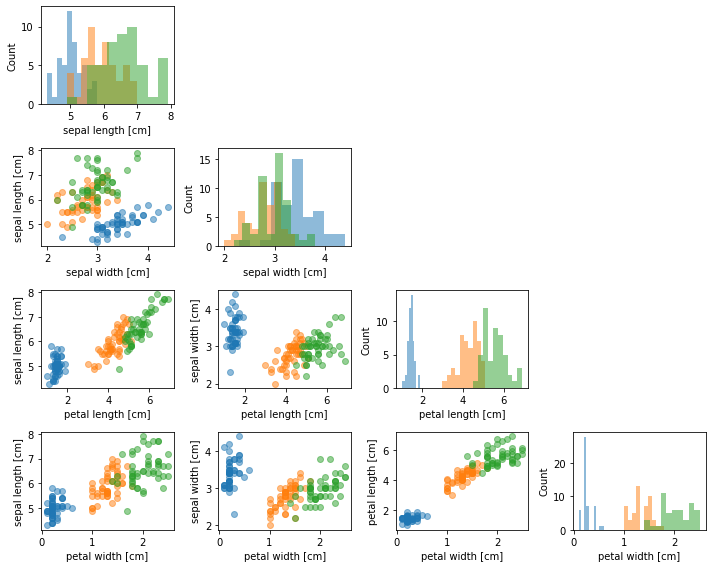

In [60]:
from mlxtend.plotting import scatterplotmatrix

names = ['sepal length [cm]', 'sepal width [cm]',
         'petal length [cm]', 'petal width [cm]']

fig, axes = scatterplotmatrix(X[y==0], figsize=(10, 8), alpha=0.5)
fig, axes = scatterplotmatrix(X[y==1], fig_axes=(fig, axes), alpha=0.5)
fig, axes = scatterplotmatrix(X[y==2], fig_axes=(fig, axes), alpha=0.5, names=names)

plt.tight_layout()
plt.show()

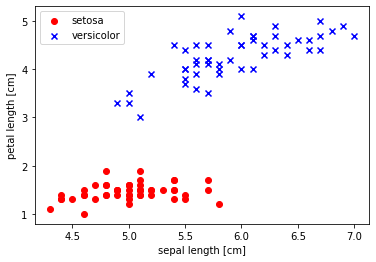

In [61]:
# select setosa and versicolor
y_temp = y[0:100]
# extract sepal length and petal length
X_temp = X[0:100, [0, 2]]

# plot data
plt.scatter(X_temp[:50, 0], X_temp[:50, 1],
            color='red', marker='o', label='setosa')
plt.scatter(X_temp[50:100, 0], X_temp[50:100, 1],
            color='blue', marker='x', label='versicolor')

plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')
plt.show()

<a id="classifier"></a>
## 2. Preprocess ,Train and Evaluate a classifier

1. [Data Scaling](#2_1)
2. [Train a model: SVM](#2_2)
3. [Evaluate the model](#2_3)

<a id="2_1"></a>
### 1. Data Scaling

Bringing features onto the same scale

In [62]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

def preprocess_minmax(X_train: np.ndarray, X_test: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Normalization -- Min-max scaling

    Scales `X_train` to [0, 1] , `X_test` to [0, 1]

    :param X_train: Data instances.
    :param X_test: Data instances.
    :return: Rescaled values of `X_train`, `X_test`.
    """
    
    # normalize
    #print('normalized:', (ex - ex.min()) / (ex.max() - ex.min()))
    
    mms = MinMaxScaler()
    X_train_norm = mms.fit_transform(X_train)
    X_test_norm = mms.transform(X_test)
    
    return X_train_norm, X_test_norm

def preprocess_standard(X_train: np.ndarray, X_test: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Standard scaling: Gaussian with zero mean and unit variance

    Scales `X_train` to [0, 1] , `X_test` to [0, 1]

    :param x: Data instances.
    :param y: Labels.
    :return: Rescaled values of `x`, `y`.
    """
    
    stdsc = StandardScaler()
    X_train_std = stdsc.fit_transform(X_train)
    X_test_std = stdsc.transform(X_test)
    
    return X_train_std, X_test_std

#### Get the dataset

In [123]:
X = df_transformed.drop(['sepal_length','sepal_width','species'], axis=1).values #0=sepal_length, 1=sepal_width 2=petal_length, 3=petal_width
y = df_transformed['species']

In [124]:
X.shape

(150, 2)

In [125]:
y.shape

(150,)

#### Split in into train/test sets

In [126]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42,shuffle=True)

#### Normalize it using Z-Score

In [127]:
# Preprocess - Training and testing set
### standard
(X_train, X_test) = preprocess_standard(X_train, X_test)

### normalize
#(X_train, X_test) = preprocess_minmax(X_train, X_test)

In [128]:
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (105, 2)
y_train.shape: (105,)
X_test.shape: (45, 2)
y_test.shape: (45,)


In [129]:
np.array(y_train)

array([1, 2, 2, 1, 2, 1, 2, 1, 0, 2, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 1,
       2, 0, 1, 2, 0, 2, 2, 1, 1, 2, 1, 0, 1, 2, 0, 0, 1, 1, 0, 2, 0, 0,
       1, 1, 2, 1, 2, 2, 1, 0, 0, 2, 2, 0, 0, 0, 1, 2, 0, 2, 2, 0, 1, 1,
       2, 1, 2, 0, 2, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 2, 2, 0,
       2, 0, 1, 2, 2, 1, 2, 1, 1, 2, 2, 0, 1, 2, 0, 1, 2])

In [136]:
# Transformed Train_Std dataframe
df_Train_Std = pd.DataFrame(
    data=X_train,
    columns=["petal_length","petal_width"])
df_Train_Std["species"] = y_train.values

# save csv file
df_Train_Std.to_csv("./data/iris_Train_Std.csv", index=False)

In [138]:
df_Train_Std.shape

(105, 3)

In [137]:
df_Train_Std.head()

,petal_length,petal_width,species
0,-0.100146,-0.321500,1
1,0.717711,0.353650,2
2,0.951384,0.758740,2
3,0.308783,0.218620,1
4,1.301894,1.703949,2


In [139]:
# Transformed Train_Std dataframe
df_Test_Std = pd.DataFrame(
    data=X_test,
    columns=["petal_length","petal_width"])
df_Test_Std["species"] = y_test.values

# save csv file
df_Test_Std.to_csv("./data/iris_Test_Std.csv", index=False)

In [140]:
df_Test_Std.shape

(45, 3)

In [141]:
df_Test_Std.head()

,petal_length,petal_width,species
0,0.484037,-0.051440,1
1,-1.268512,-1.266709,0
2,1.769240,1.433889,2
3,0.367201,0.353650,1
4,0.542456,0.218620,1


<a id="2_2_1"></a>
### 2.1 Training a Logistic Regression via scikit-learn

In [147]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty='l2', C=0.001, tol=1e-07, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(C=0.001, random_state=42, tol=1e-07)

In [148]:
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average='macro'):
    lb = LabelBinarizer()
    y_test_bin = lb.fit_transform(y_test)
    y_pred_bin = lb.fit_transform(y_pred)
    
    return metrics.roc_auc_score(y_test_bin, y_pred_bin, average)

y_pred = model.predict(X_test)
print(f"prediction: {y_pred}")
#print(f"y_true: {y_test}")
print(f'Misclassified examples:{(y_test != y_pred).sum()}')

# Accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Confusion Matrix
conf_mat = metrics.confusion_matrix(y_test, y_pred)
print(f"confusion matrix:\n {conf_mat}")

# Precision
print('\n[Precision]')
precision = metrics.precision_score(y_test, y_pred, average=None)
print(f'Individual: {precision[0]:.2f}, {precision[1]:.2f}, {precision[2]:.2f}')
precision = metrics.precision_score(y_test, y_pred, average='micro')
print(f"micro: {precision}")
precision = metrics.precision_score(y_test, y_pred, average='macro')
print(f"macro: {precision}")

# Recall
print('\n[Recall]')
recall = metrics.recall_score(y_test, y_pred, average=None)
print(f'Individual: {recall[0]:.2f}, {recall[1]:.2f}, {recall[2]:.2f}')
recall = metrics.recall_score(y_test, y_pred, average='micro')
print(f"micro: {recall}")
recall = metrics.recall_score(y_test, y_pred, average='macro')
print(f"macro: {recall}")

# F1
print('\n[F1-score]')
f1 = metrics.f1_score(y_test, y_pred, average=None)
print(f'Individual: {f1[0]:.2f}, {f1[1]:.2f}, {f1[2]:.2f}')
f1 = metrics.f1_score(y_test, y_pred, average='micro')
print(f"micro: {f1}")
f1 = metrics.f1_score(y_test, y_pred, average='macro')
print(f"macro: {f1}")

# AUC
print('\n[ROC AUC]')
auc = multiclass_roc_auc_score(y_test, y_pred, average='macro')
print(f"macro: {auc}")

# classification_report
print(f"\nclassification_report:\n {metrics.classification_report(y_test, y_pred)}")

# Predicting classes and class probabilities
print(f"\nX_test:\n {X_test[0:5,:]}")
print(f"\nclass probabilities:\n {model.predict_proba(X_test[0:5,:])}")
print(f"\nPredicting classes: {model.predict(X_test[0:5,:])}")


prediction: [2 1 2 2 2 1 1 2 2 1 2 1 1 1 1 2 2 1 2 2 1 2 1 2 2 2 2 2 1 1 1 1 2 1 1 2 2
 1 1 1 2 2 2 1 1]
Misclassified examples:29
Accuracy: 0.35555555555555557
confusion matrix:
 [[ 0 19  0]
 [ 0  3 10]
 [ 0  0 13]]

[Precision]
Individual: 0.00, 0.14, 0.57
micro: 0.35555555555555557
macro: 0.23386034255599472

[Recall]
Individual: 0.00, 0.23, 1.00
micro: 0.35555555555555557
macro: 0.4102564102564103

[F1-score]
Individual: 0.00, 0.17, 0.72
micro: 0.35555555555555557
macro: 0.29788359788359786

[ROC AUC]
macro: 0.05769230769230771

classification_report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.14      0.23      0.17        13
           2       0.57      1.00      0.72        13

    accuracy                           0.36        45
   macro avg       0.23      0.41      0.30        45
weighted avg       0.20      0.36      0.26        45


X_test:
 [[ 0.48403749 -0.05143998]
 [-1.26851205 -1.26

<a id="2_2_1"></a>
### 2.1 Training a SVM via scikit-learn

In [39]:
from sklearn.svm import SVC

model = SVC(kernel='rbf', C=0.001, random_state=42, probability=True)
model.fit(X_train, y_train)

SVC(C=0.001, probability=True, random_state=42)

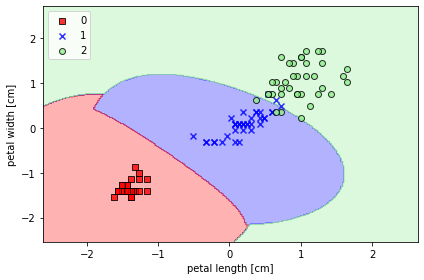

In [31]:
plot_decision_regions(X_train, y_train, model)
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

<ipython-input-64-bb5eb72466a6>:33: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(X_test[:, 0],


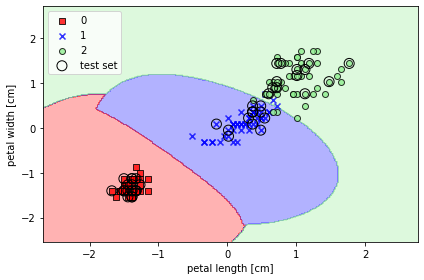

In [75]:
from matplotlib.colors import ListedColormap

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, 
                      classifier=model,
                      test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

<a id="2_3"></a>
### Evaluate the model

Looking at different performance evaluation metrics

In [40]:
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average='macro'):
    lb = LabelBinarizer()
    y_test_bin = lb.fit_transform(y_test)
    y_pred_bin = lb.fit_transform(y_pred)
    
    return metrics.roc_auc_score(y_test_bin, y_pred_bin, average)


y_pred = model.predict(X_test)
print(f"prediction: {y_pred}")
print(f"y_true: {y_test}")
print(f'Misclassified examples:{(y_test != y_pred).sum()}')

# Confusion Matrix
conf_mat = metrics.confusion_matrix(y_test, y_pred)
print(f"confusion matrix:\n {conf_mat}")

# Accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Precision
print('\n[Precision]')
precision = metrics.precision_score(y_test, y_pred, average=None)
print(f'Individual: {precision[0]:.2f}, {precision[1]:.2f}, {precision[2]:.2f}')
precision = metrics.precision_score(y_test, y_pred, average='micro')
print(f"micro: {precision}")
precision = metrics.precision_score(y_test, y_pred, average='macro')
print(f"macro: {precision}")

# Recall
print('\n[Recall]')
recall = metrics.recall_score(y_test, y_pred, average=None)
print(f'Individual: {recall[0]:.2f}, {recall[1]:.2f}, {recall[2]:.2f}')
recall = metrics.recall_score(y_test, y_pred, average='micro')
print(f"micro: {recall}")
recall = metrics.recall_score(y_test, y_pred, average='macro')
print(f"macro: {recall}")

# F1
print('\n[F1-score]')
f1 = metrics.f1_score(y_test, y_pred, average=None)
print(f'Individual: {f1[0]:.2f}, {f1[1]:.2f}, {f1[2]:.2f}')
f1 = metrics.f1_score(y_test, y_pred, average='micro')
print(f"micro: {f1}")
f1 = metrics.f1_score(y_test, y_pred, average='macro')
print(f"macro: {f1}")

# AUC
print('\n[ROC AUC]')
auc = multiclass_roc_auc_score(y_test, y_pred, average='macro')
print(f"macro: {auc}")

# classification_report
print(f"\nclassification_report:\n {metrics.classification_report(y_test, y_pred)}")

# Predicting classes and class probabilities
print(f"\nX_test:\n {X_test[0:5,:]}")
print(f"\nclass probabilities:\n {model.predict_proba(X_test[0:5,:])}")
print(f"\nPredicting classes: {model.predict(X_test[0:5,:])}")

prediction: [1 1 2 1 1 1 1 2 1 1 2 1 1 1 1 1 2 1 1 2 1 2 1 2 2 2 2 2 1 1 1 1 1 1 1 2 1
 1 1 1 2 1 1 1 1]
y_true: [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0 0 0 2 1 1 0 0]
Misclassified examples:19
confusion matrix:
 [[ 0 19  0]
 [ 0 13  0]
 [ 0  0 13]]
Accuracy: 0.5777777777777777

[Precision]


C:\Users\Hade\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hade\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass average=macro as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\Hade\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Individual: 0.00, 0.41, 1.00
micro: 0.5777777777777777
macro: 0.46875

[Recall]
Individual: 0.00, 1.00, 1.00
micro: 0.5777777777777777
macro: 0.6666666666666666

[F1-score]
Individual: 0.00, 0.58, 1.00
micro: 0.5777777777777777
macro: 0.5259259259259259

[ROC AUC]
macro: 0.25

classification_report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.41      1.00      0.58        13
           2       1.00      1.00      1.00        13

    accuracy                           0.58        45
   macro avg       0.47      0.67      0.53        45
weighted avg       0.41      0.58      0.46        45


X_test:
 [[ 0.48403749 -0.05143998]
 [-1.26851205 -1.26670948]
 [ 1.76924049  1.43388941]
 [ 0.36720086  0.35364985]
 [ 0.54245581  0.21861991]]

class probabilities:
 [[0.33606237 0.34238447 0.32155316]
 [0.33077704 0.34589579 0.32332717]
 [0.3353296  0.34525419 0.31941621]
 [0.33639327 0.3425741  0.32103264]
 [0.

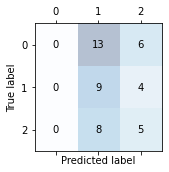

In [133]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

Max f1_score on C = 0.021  is  1.0


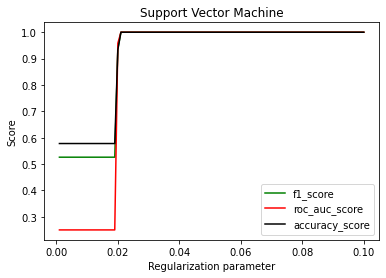

In [155]:
# imports
import time

def train_model(regularize, X_train, y_train):
    t1 = time.time()
    model = SVC(kernel='rbf', C=regularize, random_state=42, probability=True)
    model.fit(X_train, y_train)
    t2 = time.time()

    return model, t2 - t1


def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred, average='macro')
    precision = metrics.precision_score(y_test, y_pred, average='macro')
    auc = multiclass_roc_auc_score(y_test, y_pred, average='macro')
    f1 = metrics.f1_score(y_test, y_pred, average='macro')
    
    return acc, recall, precision, auc, f1


max_c = 0.0;
max_j = 0.0;

y_acc = []
y_recall = []
y_precision = []
y_auc = []
y_fsc = []

for j in np.linspace(0.001,0.1,100):
    x_vals = np.linspace(0.001,0.1,100)
    # train model
    clf, train_time = train_model(j , X_train, y_train)
    acc, recall, precision, auc, f1 = evaluate_model(clf, X_test, y_test)
    y_acc.append(acc)
    y_recall.append(recall)
    y_precision.append(precision)
    y_auc.append(auc)
    y_fsc.append(f1)
    
    if f1 > max_c:
        max_c = f1
        max_j = j
        
    
print("Max f1_score on C =",  max_j , " is ", max_c)
plt.figure()
plt.xlabel('Regularization parameter')
plt.ylabel('Score')
plt.title('Support Vector Machine')
plt.plot(x_vals, y_fsc, color = "green", label = "f1_score")
plt.plot(x_vals, y_auc, color = "red", label = "roc_auc_score")
plt.plot(x_vals, y_acc, color = "black", label = "accuracy_score")

plt.legend()

#### Receiver Operating Characteristic (ROC) Curve

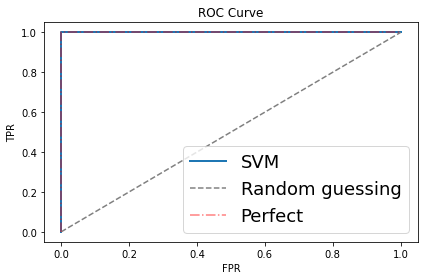

In [163]:
def train_model(X_train, y_train):
    model = SVC(kernel='rbf', C=0.021, random_state=42, probability=True)
    model.fit(X_train, y_train)
    return model


def evaluate_model(model, X_test, y_test):
    probas  = model.predict_proba(X_test)
    ## we use feature 1 as positive label
    fpr, tpr, thresholds = metrics.roc_curve(y_test,
                                 probas[:, 0],
                                 pos_label=0)

    return fpr, tpr, thresholds

clf = train_model(X_train, y_train)
fpr, tpr, thresholds = evaluate_model(clf, X_test, y_test)
plt.plot(fpr, tpr, lw=2, label='SVM')
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color='gray',
         label='Random guessing')
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle='-.',
         alpha=0.5,
         color='red',
         label='Perfect')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.legend(loc=4, prop={'size': 18})
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.show()

## 5 Adversarial-Robustness-Toolbox for scikit-learn SVC